In [ ]:
# Анализ тональности
Разработка общего конвейера
1. Чтение данных (http://study.mokoron.com/)

In [20]:
import numpy as np
import keras

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [21]:
max_words = 20000
batch_size = 32
epochs = 30
max_len = 40

In [22]:
import pandas
df_train = pandas.read_csv("data/train.csv")
df_test = pandas.read_csv("data/test.csv")
df_val = pandas.read_csv("data/val.csv")

In [65]:
df_train.describe()

,id,class
count,181467.000000,181467.000000
mean,90733.000000,0.507100
std,52385.154987,0.499951
min,0.000000,0.000000
25%,45366.500000,0.000000
50%,90733.000000,1.000000
75%,136099.500000,1.000000
max,181466.000000,1.000000


In [24]:
print("Preparing the Tokenizer...")
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_train["text"])

Preparing the Tokenizer...


In [25]:
print('Vectorizing sequence data...')
x_train = tokenizer.texts_to_sequences(df_train["text"])
x_test = tokenizer.texts_to_sequences(df_test["text"])
x_val = tokenizer.texts_to_sequences(df_val["text"])

Vectorizing sequence data...


In [26]:
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)
x_val = pad_sequences(x_val, maxlen=max_len)

In [27]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (181467, 40)
x_test shape: (22684, 40)


In [28]:
x_train

array([[    0,     0,     0, ...,    11,    10,    12],
       [    0,     0,     0, ..., 13395,    35,  3799],
       [    0,     0,     0, ..., 10394, 10395,  3800],
       ..., 
       [    0,     0,     0, ...,    35,     3,    23],
       [    0,     0,     0, ...,   219,   458,   169],
       [    0,     0,     0, ...,     4,   269,   231]])

In [29]:
print('Convert class vector to binary class matrix '
      '(for use with categorical_crossentropy)')
num_classes = 2
y_train = keras.utils.to_categorical(df_train["class"], num_classes)
y_val = keras.utils.to_categorical(df_val["class"], num_classes)
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)

Convert class vector to binary class matrix (for use with categorical_crossentropy)
y_train shape: (181467, 2)
y_val shape: (22683, 2)


In [30]:
y_val

array([[ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       ..., 
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.]])

In [31]:
print('Building model sequentially 1...')
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(num_classes))
model.add(Activation('softmax'))

Building model sequentially 1...


In [32]:
model.layers

In [33]:
print(model.to_yaml())

backend: tensorflow
class_name: Sequential
config:
- class_name: Embedding
  config:
    activity_regularizer: null
    batch_input_shape: !!python/tuple [null, 40]
    dtype: float32
    embeddings_constraint: null
    embeddings_initializer:
      class_name: RandomUniform
      config: {maxval: 0.05, minval: -0.05, seed: null}
    embeddings_regularizer: null
    input_dim: 20000
    input_length: 40
    mask_zero: false
    name: embedding_2
    output_dim: 128
    trainable: true
- class_name: Conv1D
  config:
    activation: linear
    activity_regularizer: null
    bias_constraint: null
    bias_initializer:
      class_name: Zeros
      config: {}
    bias_regularizer: null
    dilation_rate: !!python/tuple [1]
    filters: 128
    kernel_constraint: null
    kernel_initializer:
      class_name: VarianceScaling
      config: {distribution: uniform, mode: fan_avg, scale: 1.0, seed: null}
    kernel_regularizer: null
    kernel_size: !!python/tuple [3]
    name: conv1d_2
    pad

In [34]:
import graphviz
import pydot_ng as pydot
print (pydot.find_graphviz())

{'dot': 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\dot.exe', 'twopi': 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\twopi.exe', 'neato': 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\neato.exe', 'circo': 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\circo.exe', 'fdp': 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\fdp.exe', 'sfdp': 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\sfdp.exe'}


In [35]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

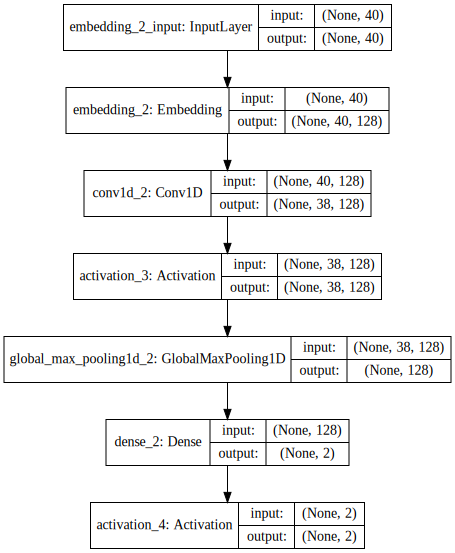

In [36]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [37]:
from keras.objectives import categorical_crossentropy
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [40]:
from keras.callbacks import TensorBoard  
tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
from keras.callbacks import EarlyStopping  
early_stopping=EarlyStopping(monitor='val_loss', patience=3)  


history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

Train on 163320 samples, validate on 18147 samples
Epoch 1/30
163320/163320 [==============================] - 24s 146us/step - loss: 0.2122 - acc: 0.9152 - val_loss: 0.6172 - val_acc: 0.7666
Epoch 2/30
163320/163320 [==============================] - 24s 144us/step - loss: 0.1070 - acc: 0.9609 - val_loss: 0.7653 - val_acc: 0.7623
Epoch 3/30
163320/163320 [==============================] - 24s 145us/step - loss: 0.0573 - acc: 0.9798 - val_loss: 0.9840 - val_acc: 0.7565
Epoch 4/30
163320/163320 [==============================] - 24s 145us/step - loss: 0.0359 - acc: 0.9872 - val_loss: 1.1506 - val_acc: 0.7559


In [41]:
score = model.evaluate(x_val, y_val, batch_size=batch_size, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

22683/22683 [==============================] - 1s 41us/step


Test score: 1.12024093578
Test accuracy: 0.759202927308


In [42]:
results = model.predict(x_test, batch_size=batch_size, verbose=1)

22684/22684 [==============================] - 1s 36us/step


In [71]:
x_text = tokenizer.texts_to_sequences(['Мне не нравится фильм. Сюжет совсем неинтересный и актеры сыграли плохо'])

x_text = pad_sequences(x_text, maxlen=max_len)

model.predict(x_text)


array([[  9.99674082e-01,   3.25976143e-04]], dtype=float32)

In [64]:
print('x_train shape:', x_text.shape)

x_train shape: (19, 40)


In [67]:
df_train['text'][0]

'Делаю пробное печенье по рецепту makeupkaty , пока что без формы) http://t.co/bRZjtMdXyd'